# Исследование надежности заемщиков


Заказчик - кредитный отдел банка. Входные данные от банка — статистика о платёжеспособности клиентов.

**Цель** проекта - исследовать влияние различных характеристик клиентов на возврат клиентом кредита в срок.   
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

В ходе исследования необходимо определить влияние следующих факторов на возврат кредита в срок:
* количество детей,
* семейное положение,
* уровень дохода,
* цели кредита

**Описание данных**

* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

## Загрузка и знакомство с данными

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
try:
    data = pd.read_csv('data_bank.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

Выведем первые строки на экран и ознакомимся с данными методом `info`.

In [3]:
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Предобработка данных

### Обработка пропусков

In [5]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Проверю, совпадают ли строки содержащие `Nan` из столбца `days_employed` со строками содержащими `Nan` из столбца `total_income`

In [6]:
nan_analysis = data[(data['days_employed'].isna()) & (data['total_income'].notna())]
nan_analysis

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


Пропуски совпадают.

Столбец с пропущенными значениями — `total_income` — хранит данные о доходах. На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце нужно медианным значением по каждому типу из столбца `income_type`. Например, у человека с типом занятости `сотрудник` пропуск в столбце `total_income` должен быть заполнен медианным доходом среди всех записей с тем же типом.

In [7]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

### Обработка аномальных значений

В датасете наблюдается аномалия - отрицательное количество дней трудового стажа в столбце `days_employed`. Заменю все отрицательные значения положительными с помощью метода `abs()`.

In [8]:
data['days_employed'] = data['days_employed'].abs()

Рассмотрим медианное значение трудового стажа `days_employed` в днях для каждого типа занятости.

In [9]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получатся аномально большие значения. Исправить такие значения сложно, поэтому оставлю их как есть, поскольку этот столбец не понадобится для дальнейшего исследования.

Рассмотрим уникальные значений столбца `children`.

In [10]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

В столбце `children` есть два аномальных значения: -1 и 20. Удалю строки, в которых встречаются такие аномальные значения из датафрейма.

In [11]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [12]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

Аномальных детей удалили.

### Обработка пропусков (продолжение)

Заполню пропуски в столбце `days_employed` медианными значениями по каждого типа занятости `income_type`.

In [13]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [14]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Пропусков не осталось.

#### Возможные причины появления пропусков в исходных данных.

Пропуски в исходных данных находились в столбцах с общим трудовым стажем в днях и  ежемесячный доход.
* Пропуск трудового стажа можно объяснить отсутствием трудовой книжки у клиента, либо неофициальным трудоустройством. 
* Пропуски в доходе можно объяснить нежеланием клиента указывать доход (хотя как ему тогда одобрят кредит?)
* Также, причинами всех данных пропусков могут быть как технические сбои, так и человеческий фактор.
* _Пропуски могут быть связаны с тем, например, что при заполнении электронной заявки на кредит, клиент оставил пустым поле с трудовым стажем и анкета не предложила ему заполнить поле с ежемесячным доходом, поскольку у человека без стажа не может быть дохода (по мнению системы). Такую причину можно отнести к технической недоработке._

### Изменение типов данных

Замению тип данных в столбце `total_income` на целочисленный.

In [15]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

Проверю столбец `education` на неявные дубликаты (в столбце имеются одинаковые значения, но в разных регистрах). Для этого приведу их к нижнему регистру и посчитаю количество дубликатов.

In [16]:
data['education'] = data['education'].str.lower()

In [17]:
data.duplicated().sum()

71

Удалим дубликаты.

In [18]:
data = data.drop_duplicates()

### Категоризация данных

Присвоим клиентам различные категории, в зависимости от их уровня дохода. 

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [19]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [20]:
data

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем
21522,1,2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость
21523,3,3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля


In [21]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Проверим на уникальность цели взятия кредита из столбца `purpose`.

In [22]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

В столбце имеются цели, схожие по смыслу, но по разному сформулированные

Создам функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:**

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

Например, если в столбце `purpose` находится подстрока `'на покупку автомобиля'`, то в столбце `purpose_category` должна появиться строка `'операции с автомобилем'`.


In [23]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [24]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Исследовательский анализ

### Влияние количества детей на возврат кредита в срок

Чтобы узнать, есть ли зависимость между количеством детей и возвратом кредита в срок, необходимо сгруппировать и обработать данные таким образом, чтобы четко проследить зависимость. 

Найти данную зависимость можно сравнив значений долей должников внутри данной категории.

Для этого предлагается построить сводную таблицу с категоризацией по детям и подсчетом количества клиентов с долгом и без. 

Далее, через отношение количества должников к клиентам без долга находим долю должников внутри категории. Чем меньше полученное значение, тем меньше должников внутри категории.

In [25]:
# Создаю таблицу с нужными мне столбцами.
children_tab = data[['children' , 'debt' , 'total_income']]

#Создаю сводную таблицу
children_pivot = children_tab.pivot_table(index = 'children' , 
                                          columns = 'debt' , 
                                          values = 'total_income' ,  
                                          aggfunc = 'count').reset_index()

children_pivot

debt,children,0,1
0,0,13028.0,1063.0
1,1,4364.0,444.0
2,2,1858.0,194.0
3,3,303.0,27.0
4,4,37.0,4.0
5,5,9.0,NaN


Сводная таблица показывает, что среди клиентов с пятью детьми должников не имеется. По идее, надо бы удалить данную строку, так как и должников нет, и клиентов без долга всего девять.
Но, чтобы получить хоть какие-то значения для зависимости, я заменю 'NaN' на ноль. 

In [26]:
children_pivot = children_pivot.fillna(value = 0)
children_pivot

debt,children,0,1
0,0,13028.0,1063.0
1,1,4364.0,444.0
2,2,1858.0,194.0
3,3,303.0,27.0
4,4,37.0,4.0
5,5,9.0,0.0


Далее найдем отношение количества клиентов имеющих долг к клиентам без долгов.

In [27]:
#Сначала переименовываю колонки для удобства: 'yes_debt' - клиенты с долгом, 'no_debt' - клиенты без долга.
children_pivot.columns = ['children', 'no_debt', 'yes_debt']

#Добавляю колонку с отношением
children_pivot['ratio'] = (children_pivot['yes_debt'] / 
                           children_pivot['no_debt'])

# Округляю количество знаков после запятой и вывожу таблицу
children_pivot['ratio'] = children_pivot['ratio'].round(decimals = 3)
children_pivot

,children,no_debt,yes_debt,ratio
0,0,13028.0,1063.0,0.082
1,1,4364.0,444.0,0.102
2,2,1858.0,194.0,0.104
3,3,303.0,27.0,0.089
4,4,37.0,4.0,0.108
5,5,9.0,0.0,0.000


Чтобы наглядно проследить зависимость, построим график по количеству детей к доле должников.

<Axes: xlabel='children', ylabel='ratio'>

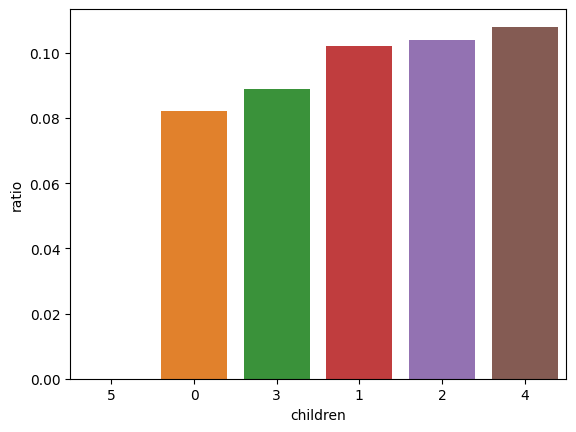

In [28]:
sns.barplot(data = children_pivot , 
            x = 'children' , 
            y = 'ratio' , 
            order = children_pivot.sort_values('ratio').children)


График показывает, что самая меньшая доля должников среди клиентов без детей. Немногим больше должников среди клиентов с тремя детьми и еще больше должников среди всех остальных категорий. 
Если бы количество должников с тремя детьми было бы на 1-2% больше можно было бы сделать вывод о влиянии количества детей на наличие долга.

Поскольку данных в категориях с 3, 4 и 5 детьми для анализа недостаточно, ниже построю график без учета данных категорий.

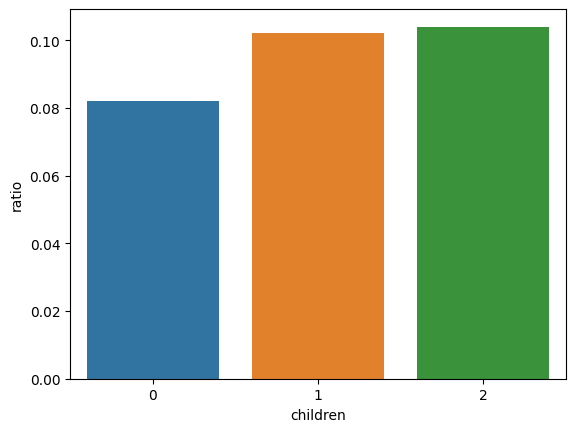

In [29]:
# Создам новую таблицу без учета категорий с недостатком данных
children_concl = children_pivot[(children_pivot['children'] != 3) & 
                                (children_pivot['children'] != 4) & 
                                (children_pivot['children'] != 5)]

# Вывожу график по новой таблице
children_concl_plot = sns.barplot(data = children_concl , 
            x = 'children' , 
            y = 'ratio' , 
            order = children_concl.sort_values('ratio').children)


Данный график показывает, что наличие детей влияет на возврат кредита в срок.

**Вывод:** 
* согласно имеющимся данным можно сделать вывод, что **наличие** детей влияет на возврат кредита в срок. Должников без детей на 2% меньше, чем должников с детьми.
* также, глядя на первый график, может показаться, что и **количество** детей влияет на возврат кредита в срок. Но для подтверждения данной гипотезы нужно больше значений.
*  ___следует отметить, что среди клиентов с 5 детьми должников не было.___

### Влияние семейного положения на возврат кредита в срок

По аналогии с предыдущим заданием построим сводную таблицу по следующим группам данных:
* Столбец по которому группируем данные - семейное положение (`family_status`),
* Столбец по которому группируем значения - долг (`debt`)

In [30]:
# Создаю таблицу с нужными мне столбцами.
family_tab = data[['family_status' , 'debt' , 'family_status_id']]

#Создаю сводную таблицу
family_pivot = family_tab.pivot_table(index = 'family_status' , 
                                      columns = 'debt' , 
                                      values = 'family_status_id' ,  
                                      aggfunc = 'count').reset_index()
family_pivot

debt,family_status,0,1
0,Не женат / не замужем,2523,273
1,в разводе,1105,84
2,вдовец / вдова,888,63
3,гражданский брак,3749,385
4,женат / замужем,11334,927


Далее найдем отношение количества клиентов имеющих долг к клиентам без долгов.

In [31]:
#Переименовываю колонки
family_pivot.columns = ['family_status', 'no_debt', 'yes_debt']

#Добавляю колонку с отношением
family_pivot['ratio'] = (family_pivot['yes_debt'] / 
                         family_pivot['no_debt'])

#Округляю значения и вывожу таблицу
family_pivot['ratio'] = family_pivot['ratio'].round(decimals = 3)
family_pivot.sort_values(by = 'ratio' , ascending = False)

,family_status,no_debt,yes_debt,ratio
0,Не женат / не замужем,2523,273,0.108
3,гражданский брак,3749,385,0.103
4,женат / замужем,11334,927,0.082
1,в разводе,1105,84,0.076
2,вдовец / вдова,888,63,0.071


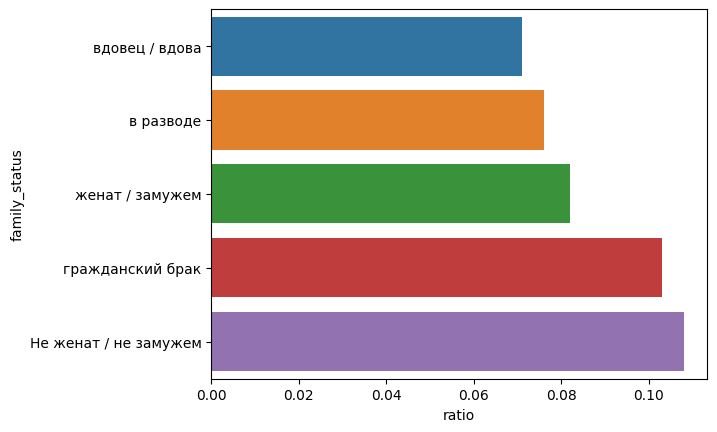

In [32]:
family_concl_plot = sns.barplot(data = family_pivot, 
            x = 'ratio' , 
            y = 'family_status' , 
            order = family_pivot.sort_values('ratio').family_status)

Полученный график показывает, что доля должников больше всего в двух группах: "не женат/не замужем" и "гражданский брак".
В остальных группах доля должников на 2-3% меньше. Меньше всего должников в группе: "вдовец/вдова".

**Вывод:**
* наибольшая доля должников в двух группах: "не женат/не замужем" - 10.8% и "гражданский брак" - 10.3%;
* наименьшая доля должников в группе "вдовец/вдова" - 7.1%.

### Влияние уровня дохода на возврат кредита в срок

По аналогии с предыдущими заданиями построим сводную таблицу по следующим группам данных:
* Столбец по которому группируем данные - категория ежемесячного дохода ('total_income_category'),
* Столбец по которому группируем значения - долг ('debt')

In [33]:
# Создаю таблицу с нужными мне столбцами.
income_tab = data[['total_income_category' , 'debt' , 'total_income']]

#Создаю сводную таблицу
income_pivot = income_tab.pivot_table(index = 'total_income_category' , 
                                      columns = 'debt' , 
                                      values = 'total_income' ,
                                      aggfunc = 'count' , 
                                      fill_value = 0).reset_index()
income_pivot

debt,total_income_category,0,1
0,A,23,2
1,B,4660,354
2,C,14568,1353
3,D,328,21
4,E,20,2


Далее найдем отношение количества клиентов имеющих долг к клиентам без долгов.

In [34]:
#Переименовываю колонки и прячу индекс
income_pivot.columns = ['total_income_category', 'no_debt', 'yes_debt']

#Добавляю колонку с отношением
income_pivot['ratio'] = (income_pivot['yes_debt'] / 
                         income_pivot['no_debt'])

#Округляю значения и вывожу таблицу
income_pivot['ratio'] = income_pivot['ratio'].round(decimals = 3)
income_pivot.sort_values(by = 'ratio' , ascending = False)

,total_income_category,no_debt,yes_debt,ratio
4,E,20,2,0.100
2,C,14568,1353,0.093
0,A,23,2,0.087
1,B,4660,354,0.076
3,D,328,21,0.064


<Axes: xlabel='total_income_category', ylabel='ratio'>

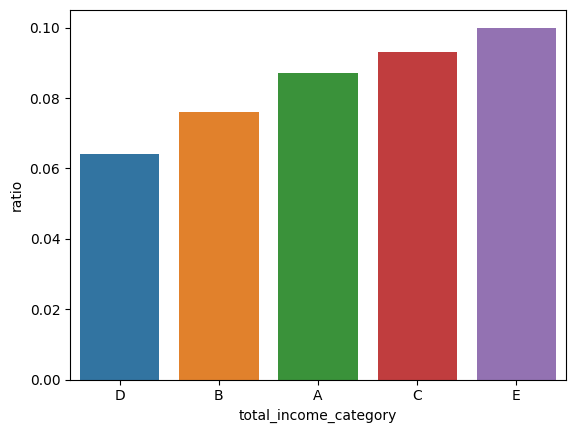

In [35]:
sns.barplot(data = income_pivot, 
            x = 'total_income_category' , 
            y = 'ratio' ,
            order = income_pivot.sort_values('ratio').total_income_category)

Согласно полученному графику, наибольшая доля должников в категории клиентов "E", то есть клиентов, чей доход в месяц менее 30000 рублей.
Наименьшая доля должников в категории клиентов "D", то есть клиентов, чей доход в месяц варьируется от 30000 до 50000 рублей.

Данных по клиентам в категориях "A", "E" и "D" - очень мало, поэтому сложно говорить о каких-либо зависимостях.

Ниже построю график без учета категорий клиентов с недостатком в данных. 

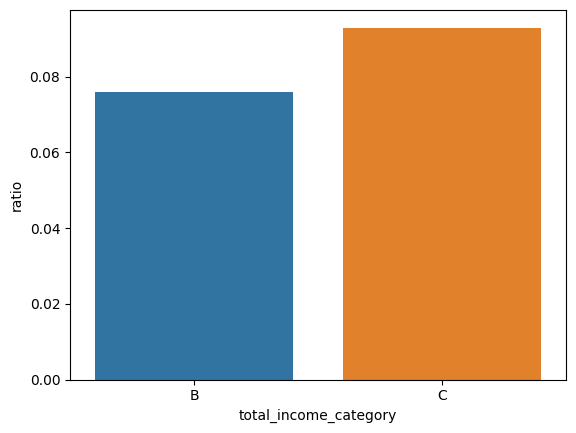

In [36]:
# Создам новую таблицу без учета категорий с недостатком данных
income_concl = income_pivot[(income_pivot['total_income_category'] != 'A') & 
                            (income_pivot['total_income_category'] != 'E') & 
                            (income_pivot['total_income_category'] != 'D')]

# Вывожу график по новой таблице
income_concl_plot = sns.barplot(data = income_concl , 
            x = 'total_income_category' , 
            y = 'ratio' , 
            order = income_concl.sort_values('ratio').total_income_category)

**Вывод:** 

С учетом всех полученных данных, можно сделать следующие выводы:
* наибольшая доля должников в категории клиентов "E" - 10.0%
* наименьшая доля должников в категории клиентов "D" - 6.4%
* если не учитывать категории в которых мало данных, то есть "A", "E" и "D", то появляется зависимость - чем меньше доход, тем больше доля должников. Должников в категории 'B' на 1.7% меньше, чем в категории 'C'.

### Влияние цели кредита на его возврат в срок

По аналогии с предыдущими заданиями построим сводную таблицу по следующим группам данных:
* Столбец по которому группируем данные - категория целей кредита (`purpose_category`),
* Столбец по которому группируем значения - долг (`debt`)

In [37]:
# Создаю таблицу с нужными мне столбцами.
purpose_tab = data[['purpose_category' , 'debt' , 'purpose']]

#Создаю сводную таблицу
purpose_pivot = purpose_tab.pivot_table(index = 'purpose_category' , 
                                        columns = 'debt' , 
                                        values = 'purpose' ,  
                                        aggfunc = 'count' , 
                                        fill_value = 0).reset_index()
purpose_pivot

debt,purpose_category,0,1
0,операции с автомобилем,3879,400
1,операции с недвижимостью,9971,780
2,получение образования,3619,369
3,проведение свадьбы,2130,183


In [38]:
#Переименовываю колонки
purpose_pivot.columns = ['purpose_category', 'no_debt', 'yes_debt']

#Добавляю колонку с отношением
purpose_pivot['ratio'] = (purpose_pivot['yes_debt'] / purpose_pivot['no_debt'])

#Округляю значения и вывожу таблицу
purpose_pivot['ratio'] = purpose_pivot['ratio'].round(decimals = 3)
purpose_pivot.sort_values(by = 'ratio' , ascending = False)

,purpose_category,no_debt,yes_debt,ratio
0,операции с автомобилем,3879,400,0.103
2,получение образования,3619,369,0.102
3,проведение свадьбы,2130,183,0.086
1,операции с недвижимостью,9971,780,0.078


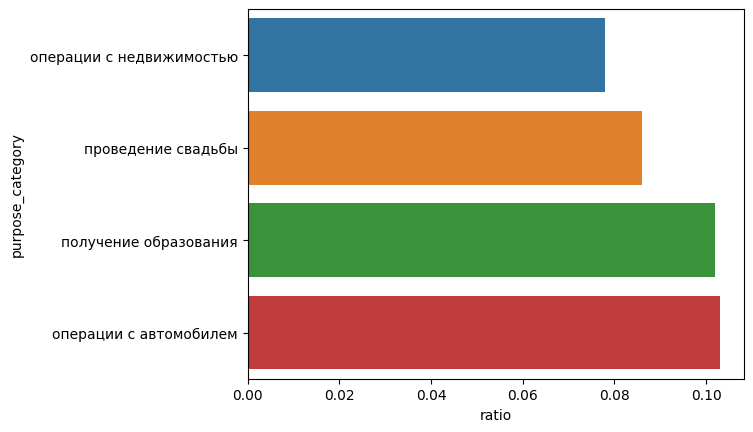

In [39]:
purpose_concl_plot = sns.barplot(data = purpose_pivot, 
            x = 'ratio' , 
            y = 'purpose_category' ,
            order = purpose_pivot.sort_values('ratio').purpose_category)

**Вывод:** 
* наибольшие доли должников в категориях целей кредита "операции с автомобилем" и "получение образования". Их значения приблизительно одинаковы - 10.3% и 10.2%.
* наименьшая доля должников в категории "операции с недвижимостью" - 7.8%. 

## Общий вывод.

В ходе работы над данным проектом были рассмотрены зависимости возврата кредита в срок от следующих характеристик клиентов:
* количество детей,
* семейное положение,
* уровень дохода,
* цели кредита.

У некоторых категорий клиентов значений наличия или отсутствия задолженности было очень мало и делать строить зависимости по этим значениям было проблематично.

Достаточное количество информации было в зависимостях от *семейного положения* и *целей кредита*.

### В зависимости от **семейного положения**:
* **наибольшая** доля должников в двух группах: 
    * "не женат/не замужем" - 10.8%,
    * "гражданский брак" - 10.3% ;


* **наименьшие** доли должников в группах: 
    * "вдовец/вдова" - 7.1%,
    * "в разводе" - 7.6%,
    * "женат / замужем" - 8.2%.

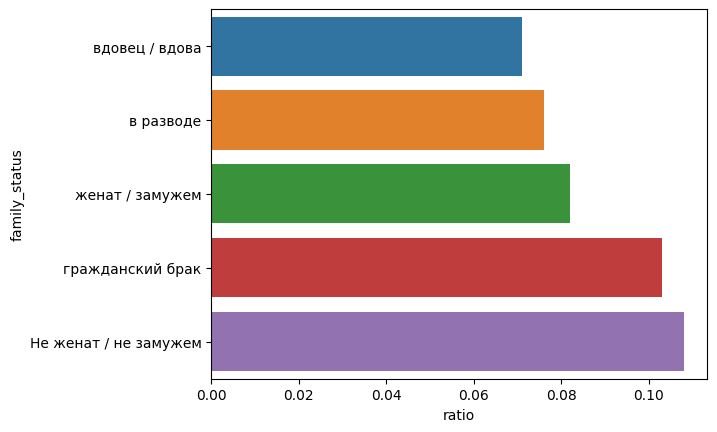

In [40]:
family_concl_plot.figure

Таким образом, можно сделать вывод, что 
>клиенты состоящие/состоявшие в браке более ответственно относятся к выплате кредитов.

Разница между максимальным и минимальным количеством должников в данной категории **всего 3.7%**. Считаю, что принимать окончательно решение при выдаче кредита,используя данную зависимость, **не рекомендуется**.


### В зависимости от **целей кредита**:
* наибольшие доли должников в категориях целей кредита:
    * "операции с автомобилем" - **10.3%**,  
    * "получение образования" - **10.2%**.
* наименьшие доли должников в категориях:
    * "операции с недвижимостью" - **7.8%**,
    * "проведение свадьбы" - **8.6%**.


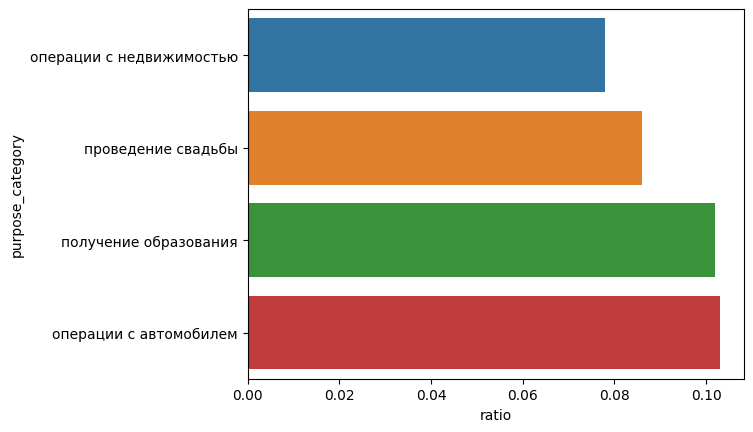

In [41]:
purpose_concl_plot.figure

Разница между максимальным и минимальным количеством должников в данной категории **всего 2.5%**. Считаю, что принимать окончательно решение при выдаче кредита,используя данную зависимость, **не рекомендуется**.

Если отсеять те категории клиентов в которых было очень мало значений, то можно сказать о следующих зависимостях:
### Зависимость от **количества детей**  
>Наличие ребенка влияет на возврат кредита в срок. 

Должников без детей на **2%** меньше, чем должников с детьми.

Должников у которых отсутствуют дети - **8.2%**. В то время как среди клиентов с одним и двумя детьми - **10.2%** и **10.4%** соответственно. 

Тем не менее, следует отметить, что среди клиентов у которых **пять детей**, должники **отсутствуют**.

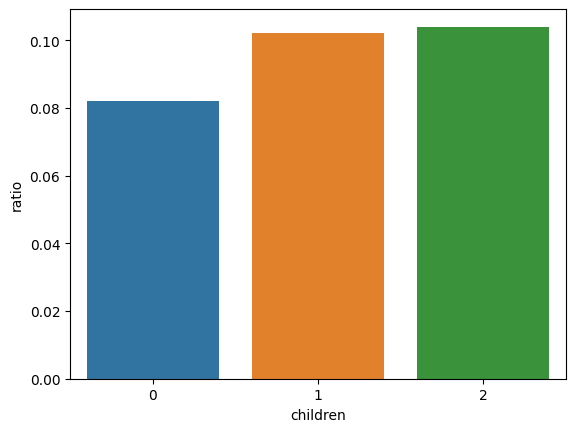

In [42]:
children_concl_plot.figure

Вывод о зависимости количества детей на возврат кредита в срок в данный момент сделать нельзя, поскольку не хватает данных по клиентам с 3, 4 и 5 детьми.
Разница между максимальным и минимальным количеством должников в данной категории **всего 2.6%**. Считаю, что учитывать данную зависимость при выдаче кредита **не рекомендуется**.

### По **уровню дохода**  
Сформировать однозначный вывод по данной категории, анализируя имеющиеся данные, невозможно - слишком маленькая выборка, как среди клиентов с минимальным доходом, так и с максимальным.

Если учесть категории в которых достаточно данных, то получается следующее:
* должников с доходом от 50000 до 200000 - **9.3%**,
* должников с доходом от 200000 до 1000000 - **7.6%**.

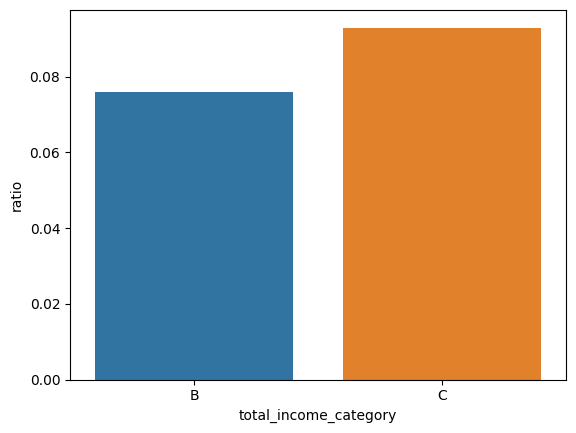

In [43]:
income_concl_plot.figure

Несмотря на то, что судя по графику появляется зависимость "чем меньше доход, тем больше доля должников", брать ее в рассчет я **не рекомендую**, поскольку:
* не хватает анализа по остальным категориям клиентов,
* разница между данными категориями составляет всего **1.7%**.

### Резюме

* Анализ данных показал, что при выдаче кредита можно использовать зависимости **погашения кредита в срок** от **семейного положения** и **целей кредита**.
* Для использования зависимости **погашения кредита в срок** от **количества детей** и **уровня дохода** рекомендуется провести повторное исследование с большей выборкой данных.
* Рекомендуется проверить электронную систему заполнения анкет на выдачу кредитов касаемо взаимосвязи **общего трудового стажа** и **ежемесячного дохода**, поскольку в них очень много пропущенных значений.